In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# stationary dist

In [2]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E, ell  = sp.symbols('a b x g p C E lambda')

In [3]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-(1-ell)*(b-C))) + a*p*(1-sp.Min(sp.exp(-(1-ell)*(b-C-E)),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [4]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [5]:
p1_sym

a*((2*a*p - 2*a - p + 1)*exp(C*lambda - C - b*lambda + b) + (-2*a*p*Min(1, exp(-C*lambda + C - E*lambda + E + b*lambda - b)) + 2*a + p*Min(1, exp(-C*lambda + C - E*lambda + E + b*lambda - b)) - 1)*exp(2*C*lambda - 2*C - 2*b*lambda + 2*b))*exp(-C*lambda + C + b*lambda - b)/(3*a**2*p - 3*a**2 - 2*a*p + 2*a + (-3*a**2*p*Min(1, exp(-C*lambda + C - E*lambda + E + b*lambda - b)) + 3*a**2 + 2*a*p*Min(1, exp(-C*lambda + C - E*lambda + E + b*lambda - b)) - 1)*exp(C*lambda - C - b*lambda + b))

## FIXED

In [6]:
# 3 cases for f0
f0i_fixed   = C * (a*p*sp.Min(1,sp.exp(-(1-ell)*(b-C-E))) + a*(1-p)*sp.exp(-(1-ell)*(b-C)))
f0ii_fixed  = a*C * (a*p*(1-sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))) + a*(1-p)*(1-sp.exp(-(1-ell)*(b-C))))
f0iii_fixed = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))) + a*(1-p)*(1-sp.exp(-(1-ell)*(b-C))))
f0iii_fixed

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp((lambda - 1)*(-C - E + b)))) + a*(1 - p)*(1 - exp((-C + b)*(lambda - 1))))

In [7]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)
f0_fixed

C*a*(a*p*(1 - Min(1, exp((lambda - 1)*(-C - E + b)))) + a*(1 - p)*(1 - exp((-C + b)*(lambda - 1)))) + C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp((lambda - 1)*(-C - E + b)))) + a*(1 - p)*(1 - exp((-C + b)*(lambda - 1)))) + C*(a*p*Min(1, exp((lambda - 1)*(-C - E + b))) + a*(1 - p)*exp((-C + b)*(lambda - 1)))

In [8]:
attack_full_fixed  = p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a))

## Bernoulli

In [9]:
f0i_bern   = E * (a*p*sp.Min(1,sp.exp(-(1-ell)*(b-C-E))))
f0ii_bern  = a*E * (a*p*(1-sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))))
f0iii_bern = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp((lambda - 1)*(-C - E + b))))*(a + g*(1 - a))

In [10]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [11]:
attack_full_bern  = p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a))

## Linear

In [12]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+1/(1-ell))*sp.Min(1,sp.exp(-(1-ell)*(b-C-E))) \
            + a*(1-p)*(1/(1-ell)+(b-C))*sp.exp(-(1-ell)*(b-C))
f0ii_lin  = a* (a*p*(1/(1-ell)-(sp.Max(0,b-C-E)+1/(1-ell))*sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))) \
            + a*(1-p)*(1/(1-ell)-(1/(1-ell)+(b-C))*sp.exp(-(1-ell)*(b-C))))
f0iii_lin = ((1-a)*(a+g*(1-a))) \
            * (a*p*(1/(1-ell)-(sp.Max(0,b-C-E)+1/(1-ell))*sp.Min(1,sp.exp(-(1-ell)*(b-C-E)))) \
            + a*(1-p)*(1/(1-ell)-(1/(1-ell)+(b-C))*sp.exp(-(1-ell)*(b-C))))
f0iii_lin

(1 - a)*(a + g*(1 - a))*(a*p*(-(Max(0, -C - E + b) + 1/(1 - lambda))*Min(1, exp((lambda - 1)*(-C - E + b))) + 1/(1 - lambda)) + a*(1 - p)*(-(-C + b + 1/(1 - lambda))*exp((-C + b)*(lambda - 1)) + 1/(1 - lambda)))

In [17]:
f0iii_lin.subs({p:0, C:0})

a*(1 - a)*(a + g*(1 - a))*(-(b + 1/(1 - lambda))*exp(b*(lambda - 1)) + 1/(1 - lambda))

In [13]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = a + 2*a*(1-a)

In [390]:
attack_full_lin = p0*f0_lin + p1*f1_lin + p1*a*a*(3-2*a)/(1-2*a)

# threshold alphas

In [643]:
gammas = np.arange(0.001, 1.1, 0.1)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)

In [644]:
p_ = 0.5
C_ = 1.
E_ = 2.

In [645]:
subs = {C:C_, E:E_, p:p_}

In [646]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)

In [687]:
full_rews = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_two   = ((1/(1-ell))*attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [688]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [698]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(1/(1-ell_)*attack_fixed.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_+0.0015):
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

11it [01:10,  6.37s/it]


(11,)

In [695]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(1/(1-ell_)*attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_+0.0015):
            l_res.append(a_)
            break
l_res = np.array(l_res)
l_res.shape

11it [00:39,  3.61s/it]


(11,)

In [696]:
f_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
#     cand_alphas = alphas
    for a_ in cand_alphas:
        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(1/(1-ell_)*full_rews.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*full_rews.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        if rew/3 > (a_+0.0015):
            f_res.append(a_)
            break
f_res = np.array(f_res)
f_res.shape

11it [00:20,  1.87s/it]


(11,)

In [663]:
starting_alphas = .7*np.linspace(0.25, 0.0, len(gammas))

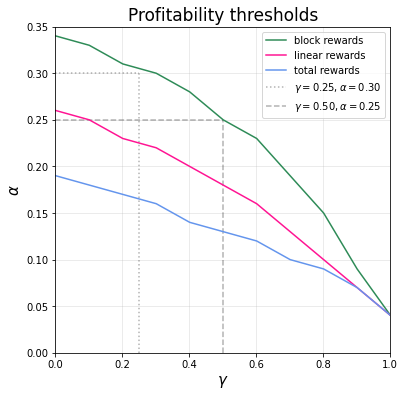

In [701]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, color='black')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,.35)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# profit as a function of alpha

In [591]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [520]:
subs = {C:C_, E:E_, p:p_}

In [521]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_full = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [522]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [530]:
betas

array([1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01, 4.51])

In [557]:
selfish_rews = []
linear_rews  = []
total_rews   = []
for i, a_ in tqdm(enumerate(alphas)):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_full.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

49it [00:38,  1.28it/s]


((49,), (49,), (49,))

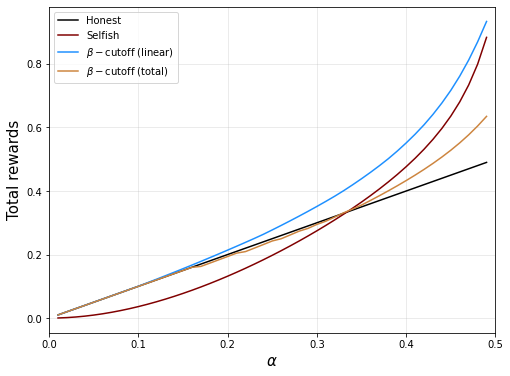

In [558]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish', color='maroon')
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue')
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Total rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

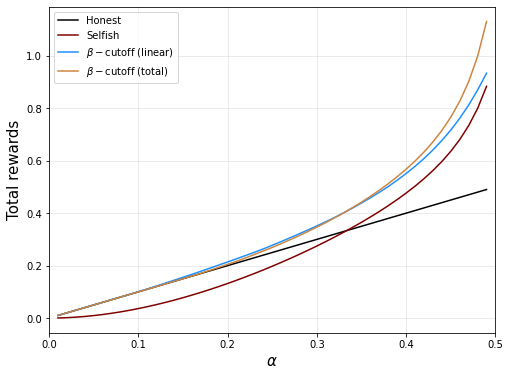

In [556]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews, label='Selfish', color='maroon')
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue')
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Total rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [569]:
selfish_rews = []
linear_rews  = []
total_rews   = []

for g_ in [0, 0.5, 1.0]:
    temp_s, temp_l, temp_t = [],[],[]
    for i, a_ in tqdm(enumerate(alphas)):
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp_s.append(rew)

        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp_l.append(rew)

        temp = []
        for b_ in betas:
            ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
            temp.append((1/(1-ell_))*attack_full.subs({a:a_, b:b_, g:g_, ell:ell_}))
        bestBeta = betas[np.argmax(temp)]
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = (1/(1-bestEll))*attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
#         rew      = attack_full.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp_t.append(rew)
    selfish_rews.append(temp_s)
    linear_rews.append(temp_l)
    total_rews.append(temp_t)
selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

49it [00:38,  1.28it/s]
49it [00:38,  1.26it/s]
49it [00:38,  1.27it/s]


((3, 49), (3, 49), (3, 49))

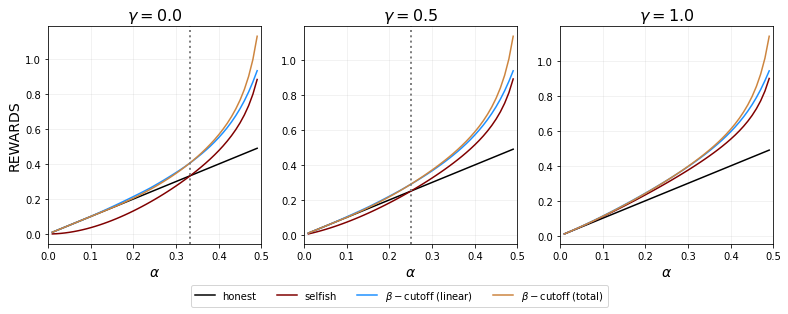

In [590]:
f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(13,4))

axarr[0].plot(alphas, alphas, color='black', label='honest')
axarr[0].plot(alphas, selfish_rews[0,:], color='maroon', label='selfish')
axarr[0].plot(alphas, linear_rews[0,:], color='dodgerblue', label=r'$\beta-$cutoff (linear)')
axarr[0].plot(alphas, total_rews[0,:]/3, color='peru', label=r'$\beta-$cutoff (total)')

axarr[1].plot(alphas, alphas, color='black', label='honest')
axarr[1].plot(alphas, selfish_rews[1,:], color='maroon', label='selfish')
axarr[1].plot(alphas, linear_rews[1,:], color='dodgerblue', label=r'$\beta-$cutoff (linear)')
axarr[1].plot(alphas, total_rews[1,:]/3, color='peru', label=r'$\beta-$cutoff (total)')

axarr[2].plot(alphas, alphas, color='black', label='honest')
axarr[2].plot(alphas, selfish_rews[2,:], color='maroon', label='selfish')
axarr[2].plot(alphas, linear_rews[2,:], color='dodgerblue', label=r'$\beta-$cutoff (linear)')
axarr[2].plot(alphas, total_rews[2,:]/3, color='peru', label=r'$\beta-$cutoff (total)')

axarr[0].set_title(r'$\gamma=0.0$', size=16)
axarr[1].set_title(r'$\gamma=0.5$', size=16)
axarr[2].set_title(r'$\gamma=1.0$', size=16)

axarr[0].axvline(1/3, color='gray', label=r'$\alpha=1/3$', linestyle='dotted', linewidth=2)
axarr[1].axvline(1/4, color='gray', label=r'$\alpha=1/4$', linestyle='dotted', linewidth=2)


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlim(0,0.5)
    ax.set_xlabel(r'$\alpha$', size=14)
    
axarr[0].set_ylabel('REWARDS', size=14)

handles, labels = axarr[2].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=5)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# interpolation

In [628]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [629]:
subs = {C:C_, E:E_, p:p_}

In [630]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_two   = ((1/(1-ell))*attack_full_fixed + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [631]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [632]:
betas

array([1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01, 4.51])

In [633]:
selfish_rews = []
linear_rews  = []
total_rews   = []
for i, a_ in tqdm(enumerate(alphas)):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_lin.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_lin.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    linear_rews.append(rew)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_two.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_two.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
linear_rews = np.array(linear_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, linear_rews.shape, total_rews.shape

49it [00:36,  1.33it/s]


((49,), (49,), (49,))

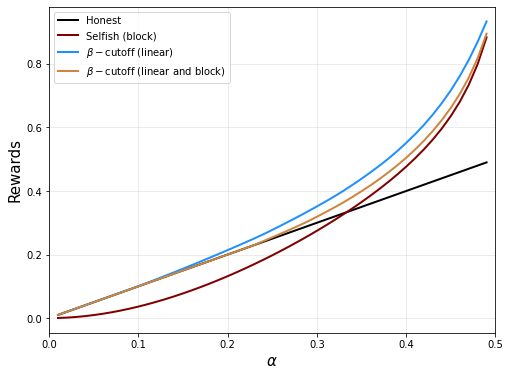

In [634]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon', linewidth=2)
    ax_.plot(alphas, linear_rews, label=r'$\beta-$cutoff (linear)', color='dodgerblue', linewidth=2)
    ax_.plot(alphas, total_rews/2, label=r'$\beta-$cutoff (linear and block)', color='peru', linewidth=2)
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# bernoulli and total

In [635]:
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

In [636]:
subs = {C:C_, E:E_, p:p_}

In [637]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)
attack_bern  =  attack_full_bern.subs({p1:p1_sym}).subs(subs)
attack_three = ((1/(1-ell))*(attack_full_fixed+attack_full_bern) + attack_full_lin).subs({p1:p1_sym}).subs(subs)

In [638]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [639]:
betas

array([1.01, 1.51, 2.01, 2.51, 3.01, 3.51, 4.01, 4.51])

In [640]:
selfish_rews = []
bern_rews  = []
total_rews   = []
for i, a_ in tqdm(enumerate(alphas)):
    bestBeta = 100.
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    selfish_rews.append(rew)

    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append((1/(1-ell_))*attack_bern.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = (1/(1-bestEll))*attack_bern.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    bern_rews.append(rew)
    
    temp = []
    for b_ in betas:
        ell_ = sp.nsolve(eq1.subs({a:a_, b:b_, g:g_}), ell, 0.1)
        temp.append(attack_three.subs({a:a_, b:b_, g:g_, ell:ell_}))
    bestBeta = betas[np.argmax(temp)]
    bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
    rew      = attack_three.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
    total_rews.append(rew)

selfish_rews = np.array(selfish_rews)
bern_rews = np.array(bern_rews)
total_rews = np.array(total_rews)
selfish_rews.shape, bern_rews.shape, total_rews.shape

49it [00:39,  1.25it/s]


((49,), (49,), (49,))

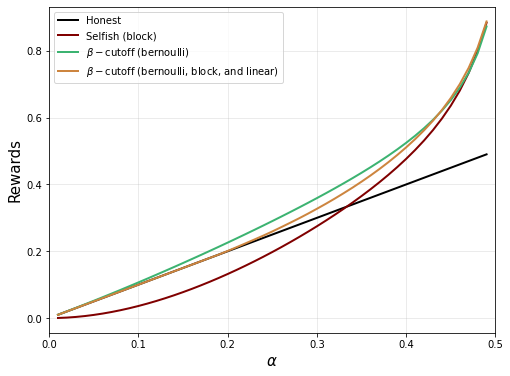

In [642]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews, label='Selfish (block)', color='maroon', linewidth=2)
    ax_.plot(alphas, bern_rews, label=r'$\beta-$cutoff (bernoulli)', color='mediumseagreen', linewidth=2)
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (bernoulli, block, and linear)', color='peru', linewidth=2)
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)
# ax.set_ylim(0,1.)
ax.legend(loc=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# sims

In [113]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.5] # using E=1, C=1

In [106]:
subs = {C:1., E:1., g:0., ell:0.}
attack_fixed_lambda = sp.lambdify((a, b, p), attack_full_fixed.subs({p1:p1_sym}).subs(subs))
attack_bern_lambda = sp.lambdify((a, b, p), attack_full_bern.subs({p1:p1_sym}).subs(subs))
attack_lin_lambda = sp.lambdify((a, b, p), attack_full_lin.subs({p1:p1_sym}).subs(subs))

In [107]:
theo_res_fixed = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_fixed_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    theo_res_fixed.append(temp1)
theo_res_fixed = np.array(theo_res_fixed)
theo_res_fixed.shape

(5, 225, 1)

In [108]:
theo_res_bern = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_bern_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    theo_res_bern.append(temp1)
theo_res_bern = np.array(theo_res_bern)
theo_res_bern.shape

(5, 225, 1)

In [111]:
theo_res_lin = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_lin_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    theo_res_lin.append(temp1)
theo_res_lin = np.array(theo_res_lin)
theo_res_lin.shape

(5, 225, 1)

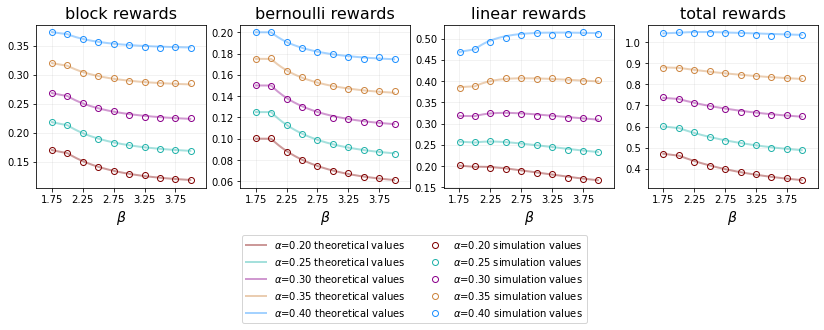

In [127]:
f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(14,3))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []


ax = axarr[0]
for j, a_ in enumerate(alphas):
    line, = ax.plot(betas, theo_res_fixed[j,:,0], linewidth=2, color=colors[j], alpha=0.4,
                    label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
ax = axarr[1]
for j, a_ in enumerate(alphas):
    line, = ax.plot(betas, theo_res_bern[j,:,0], linewidth=2, color=colors[j], alpha=0.4,
                    label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
ax = axarr[2]
for j, a_ in enumerate(alphas):
    line, = ax.plot(betas, theo_res_lin[j,:,0], linewidth=2, color=colors[j], alpha=0.4,
                    label=r'$\alpha$={:0.2f} theoretical values'.format(a_))


ax = axarr[0]
for j, a_ in enumerate(alphas):
    marker, = ax.plot(sim_betas, sim_res_fixed[j,:,0], marker='o', color=colors[j], linestyle='none', 
                      fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
ax = axarr[1]
for j, a_ in enumerate(alphas):
    marker, = ax.plot(sim_betas, sim_res_bern[j,:,0], marker='o', color=colors[j], linestyle='none', 
                      fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
ax = axarr[2]
for j, a_ in enumerate(alphas):
    marker, = ax.plot(sim_betas, sim_res_lin[j,:,0], marker='o', color=colors[j], linestyle='none', 
                      fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))

for j, a_ in enumerate(alphas):
    total_rews = theo_res_fixed[j,:,0]+theo_res_bern[j,:,0]+theo_res_lin[j,:,0]
    axarr[3].plot(betas, total_rews, linewidth=2, color=colors[j], alpha=0.4,
                  label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
    
    total_sim_rews = sim_res_fixed[j,:,0]+sim_res_bern[j,:,0]+sim_res_lin[j,:,0]
    marker, = axarr[3].plot(sim_betas, total_sim_rews, marker='o', color=colors[j], linestyle='none', 
                      fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
    

axarr[0].set_title(r'block rewards', size=16)
axarr[1].set_title(r'bernoulli rewards', size=16)
axarr[2].set_title(r'linear rewards', size=16)
axarr[3].set_title(r'total rewards', size=16)

for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlim(1.5, 4.25)
    ax.set_xticks(np.arange(1.75,4.01,0.5))
    ax.set_xlabel(r'$\beta$', size=14)
    
handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)


plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [114]:
n=int(5e5)
sim_betas = np.arange(1.751, 4.1, 0.25)
sim_betas

array([1.751, 2.001, 2.251, 2.501, 2.751, 3.001, 3.251, 3.501, 3.751,
       4.001])

In [115]:
sim_res_fixed = []
sim_res_bern  = []
sim_res_lin   = []
for a_ in alphas:
    temp1_fixed = []
    temp1_bern  = []
    temp1_lin  = []
    for b_ in tqdm(sim_betas):
        temp2_fixed = []
        temp2_bern  = []
        temp2_lin  = []
        for p_ in ps:
            honestBlc, attackBlc, honestBer, attackBer, honestLin, attackLin, time = simAllRews(
                a=a_, b=b_, g=0., p=p_, C=1., E=1., n=n)
            temp2_fixed.append(attackBlc/time)
            temp2_bern.append(attackBer/time)
            temp2_lin.append(attackLin/time)
        temp1_fixed.append(temp2_fixed)
        temp1_bern.append(temp2_bern)
        temp1_lin.append(temp2_lin)
    sim_res_fixed.append(temp1_fixed)
    sim_res_bern.append(temp1_bern)
    sim_res_lin.append(temp1_lin)
sim_res_fixed = np.array(sim_res_fixed)
sim_res_bern = np.array(sim_res_bern)
sim_res_lin = np.array(sim_res_lin)
sim_res_fixed.shape, sim_res_bern.shape, sim_res_lin.shape

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


((5, 10, 1), (5, 10, 1), (5, 10, 1))

In [73]:
# simluation code
def simAllRews(a, b, g, p, C, E, n):
    gamma = g
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-C-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b-C:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1*C
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1*C
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2*C
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1*C
                    honestBlcs += 1*C
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2*C
                    honestRews += (curTime - lastState0) + nextExecRews
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]*C
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1*C
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1*C
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs, honestBern, attackBern, honestRews, attackRews, curTime

In [192]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)

In [193]:
orphan_full = p0p * o_0p + o_rest
orphan_full

a*p_1*(1 - a)/(1 - 2*a) + p_1*(1 - a)

In [194]:
eq1 = sp.Eq(orphan_full, ell)
eq1

Eq(a*p_1*(1 - a)/(1 - 2*a) + p_1*(1 - a), lambda)

In [195]:
sols = sp.nsolve(eq1.subs({p1:p1_sym}).subs({a:0.3, b:1000.00001, g:0., p:0, C:1., E:0.}), ell, 0.1)

In [196]:
sols

0.201369863013699

In [3]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.0025)
betas = np.arange(1.01, 5.01, 0.01)

In [700]:
p_ = 0.5
C_ = 1.

In [701]:
p1_ev = p1_sym.evalf(subs={C:1., E:1., p:0.5})
p1_ev

a*(-1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.0*a - 2.71828182845905*a*exp(-b) + 0.5*Min(1.0, 7.38905609893065*exp(-b)) - 1.0 + 1.35914091422952*exp(-b))/(-1.5*a**2*Min(1.0, 7.38905609893065*exp(-b)) + 3.0*a**2 - 4.07742274268857*a**2*exp(-b) + 1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.71828182845905*a*exp(-b) - 1.0)

In [702]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})

In [703]:
br = sp.simplify(attacker_final_fixed/(attacker_final_fixed+honest_final_fixed))
br_lambda = sp.lambdify((a,b,g), br, 'numpy')
br_lambda = np.vectorize(br_lambda)
br_lambda

In [704]:
lin = sp.simplify(attack_final_lin)
lin_lambda = sp.lambdify((a,b,g), lin)
lin_lambda

<function _lambdifygenerated(a, b, g)>

In [705]:
bern = sp.simplify(attack_final_bern/(attack_final_bern+honest_final_bern))

In [713]:
full = (br + lin + bern)/3
full_lambda = sp.lambdify((a,b,g), full)

In [730]:
starting_alphas = np.linspace(0.25, 0.0, len(gammas))
starting_alphas = starting_alphas**(1/6)-0.57

In [709]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        br_lambda = np.vectorize(sp.lambdify((b), br.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = br_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

99it [02:03,  1.25s/it]


(99,)

In [710]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        lin_lambda = np.vectorize(sp.lambdify((b), lin.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = lin_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

99it [01:18,  1.26it/s]


(99,)

In [732]:
f_res = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        full_lambda_inner = np.vectorize(sp.lambdify((b), full.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = full_lambda_inner(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

99it [02:05,  1.27s/it]


(99,)

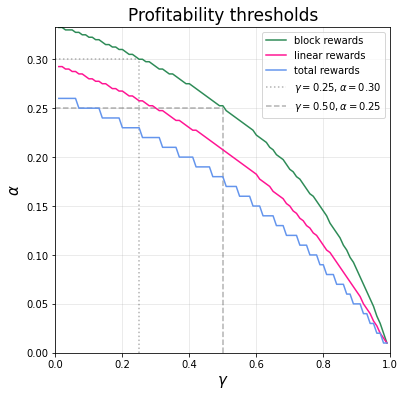

In [733]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas**(1/6)-0.57, label='total rewards', color='cornflowerblue')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.0025)
betas = np.arange(1.01, 5.01, 0.01)

p_ = 0.5
C_ = 1.

p1_ev = p1_sym.evalf(subs={C:1., E:1., p:0.5})
p1_ev

honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})

br = sp.simplify(attacker_final_fixed/(attacker_final_fixed+honest_final_fixed))
br_lambda = sp.lambdify((a,b,g), br, 'numpy')
br_lambda = np.vectorize(br_lambda)
br_lambda

lin = sp.simplify(attack_final_lin)
lin_lambda = sp.lambdify((a,b,g), lin)
lin_lambda

bern = sp.simplify(attack_final_bern/(attack_final_bern+honest_final_bern))

full = (br + lin + bern)/3
full_lambda = sp.lambdify((a,b,g), full)

starting_alphas = np.linspace(0.25, 0.0, len(gammas))
starting_alphas = starting_alphas**(1/6)-0.57

b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        br_lambda = np.vectorize(sp.lambdify((b), br.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = br_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        lin_lambda = np.vectorize(sp.lambdify((b), lin.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = lin_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

f_res = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        full_lambda_inner = np.vectorize(sp.lambdify((b), full.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = full_lambda_inner(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas**(1/6)-0.57, label='total rewards', color='cornflowerblue')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Simulations & Theory for fixed block rewards under \beta cutoff strategy

In [2]:
# simluation code
def simAllRews(a, b, g, p, C, E, n):
    gamma = g
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-C-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b-C:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1*C
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1*C
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2*C
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1*C
                    honestBlcs += 1*C
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2*C
                    honestRews += (curTime - lastState0) + nextExecRews
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]*C
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p 
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1*C
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1*C
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs, honestBern, attackBern, honestRews, attackRews, curTime

In [3]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
sim_betas = np.arange(1.751, 4.1, 0.125)
sim_betas

array([1.751, 1.876, 2.001, 2.126, 2.251, 2.376, 2.501, 2.626, 2.751,
       2.876, 3.001, 3.126, 3.251, 3.376, 3.501, 3.626, 3.751, 3.876,
       4.001])

In [43]:
sim_res_fixed = []
sim_res_bern  = []
sim_res_lin   = []
for a in alphas:
    temp1_fixed = []
    temp1_bern  = []
    temp1_lin  = []
    for b in tqdm(sim_betas):
        temp2_fixed = []
        temp2_bern  = []
        temp2_lin  = []
        for p in ps:
            honestBlc, attackBlc, honestBer, attackBer, honestLin, attackLin = simAllRews(
                a=a, b=b, p=p, C=1, E=1, n=int(15e5))
            temp2_fixed.append(attackBlc/(attackBlc+honestBlc))
            temp2_bern.append(attackBer/(attackBer+honestBer))
            temp2_lin.append(attackLin/(attackLin+honestLin))
        temp1_fixed.append(temp2_fixed)
        temp1_bern.append(temp2_bern)
        temp1_lin.append(temp2_lin)
    sim_res_fixed.append(temp1_fixed)
    sim_res_bern.append(temp1_bern)
    sim_res_lin.append(temp1_lin)
sim_res_fixed = np.array(sim_res_fixed)
sim_res_bern = np.array(sim_res_bern)
sim_res_lin = np.array(sim_res_lin)
sim_res_fixed.shape, sim_res_bern.shape, sim_res_lin.shape

100%|██████████| 19/19 [08:28<00:00, 26.77s/it]


((5, 19, 3), (5, 19, 3), (5, 19, 3))

# Theoretical for fixed rewards

In [5]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [6]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [7]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [8]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [9]:
# confirming the symbolic solver and my by hand solver have same values
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [10]:
# 3 cases for f0
f0i_fixed   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii_fixed  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [11]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)
f0_fixed

C*a*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(a*p*Min(1, exp(C + E - b)) + a*(1 - p)*exp(C - b))

In [12]:
attacker_full_fixed  = p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attacker_final_fixed = sp.simplify(attacker_full_fixed.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attacker_final_fixed

a*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(1.0*a*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 1.0*a*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + 1.0*p*exp(b)*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p + 2.71828182845905))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.1226

In [13]:
attacker_final_fixed_lambda = sp.lambdify((a, b, p), attacker_final_fixed)
attacker_final_fixed_lambda

<function _lambdifygenerated(a, b, p)>

In [14]:
g0_fixed   = C*(1-a)
g1_fixed   = C*(1-a)*(1-a)*(1-g)
g0p_fixed  = C*(1-a)
g0pp_fixed = C*(1-a)

In [15]:
honest_full_fixed = p0*g0_fixed + p1*g1_fixed + p0p*g0p_fixed + p0pp*g0pp_fixed
honest_final_fixed = honest_full_fixed.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
honest_final_fixed

1.0*a**2*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*ex

In [16]:
honest_final_fixed_lambda = sp.lambdify((a, b, p), honest_final_fixed)
honest_final_fixed_lambda

<function _lambdifygenerated(a, b, p)>

In [17]:
theo_res_fixed = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attacker_final_fixed_lambda(a=a_, b=b_, p=p_)
            honest = honest_final_fixed_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    theo_res_fixed.append(temp1)
theo_res_fixed = np.array(theo_res_fixed)
theo_res_fixed.shape

(5, 225, 3)

# Theoretical for Bernoulli rewards

In [18]:
f0i_bern   = E * (a*p*sp.Min(1,sp.exp(-b+C+E)))
f0ii_bern  = a*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp(C + E - b)))*(a + g*(1 - a))

In [19]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [20]:
attack_full_bern  = p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attack_final_bern = sp.simplify(attack_full_bern.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attack_final_bern

a*p*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(a*(a - 1.0)*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) - a*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) + Min(1.0, 7.38905609893065*exp(-b)))*exp(b))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.122626480390481*(3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) - 3.0*a**2 - 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b)))

In [21]:
attack_final_bern_lambda = sp.lambdify((a, b, p), attack_final_bern)
attack_final_bern_lambda

<function _lambdifygenerated(a, b, p)>

In [22]:
g0_bern   = p*E*(1-a)
g1_bern   = p*E*(1-a)*(1-a)*(1-g)
g0p_bern  = p*E*(1-a)
g0pp_bern = p*E*(1-a)

In [23]:
honest_full_bern = p0*g0_bern + p1*g1_bern + p0p*g0p_bern + p0pp*g0pp_bern
honest_final_bern = honest_full_bern.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
honest_final_bern

1.0*a**2*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*p*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893

In [24]:
honest_final_bern_lambda = sp.lambdify((a, b, p), honest_final_bern)
honest_final_bern_lambda

<function _lambdifygenerated(a, b, p)>

In [25]:
theo_res_bern = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_final_bern_lambda(a=a_, b=b_, p=p_)
            honest = honest_final_bern_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    theo_res_bern.append(temp1)
theo_res_bern = np.array(theo_res_bern)
theo_res_bern.shape

(5, 225, 3)

# Theoretical for linear rewards

In [35]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*(b-C+1)*sp.exp(-b+C)
f0ii_lin  = a* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C))) 
f0iii_lin = ((1-a)*(a+g*(1-a)))* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C)))
f0iii_lin

(1 - a)*(a + g*(1 - a))*(a*p*(-(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1))

In [37]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = a + 2*a*(1-a)

In [38]:
attack_full_lin = p0*f0_lin + p1*f1_lin + p1*a*a*(3-2*a)/(1-2*a)
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attack_final_lin = sp.simplify(attack_full_lin.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attack_final_lin

0.122626480390481*a*(a**2*(2.0*a - 3.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - a*(2.0*a - 3.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + (2.0*a - 1.0)*(-a*(a - 1.0)*(p*((Max(0, b - 2.0) + 1.0)*Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + a*(p*((Max(0, b - 2.0) + 1.0)*Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + 2.71828182845905*b*(p - 1.0) - p*(Max(0, b - 2.0) + 1.0)*exp(b)*Min(1.0, 7.38905609893065*exp(-b))))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 

In [39]:
attack_final_lin_lambda = sp.lambdify((a, b, p), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p)>

In [40]:
theo_res_lin = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_final_lin_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    theo_res_lin.append(temp1)
theo_res_lin = np.array(theo_res_lin)
theo_res_lin.shape

(5, 225, 3)

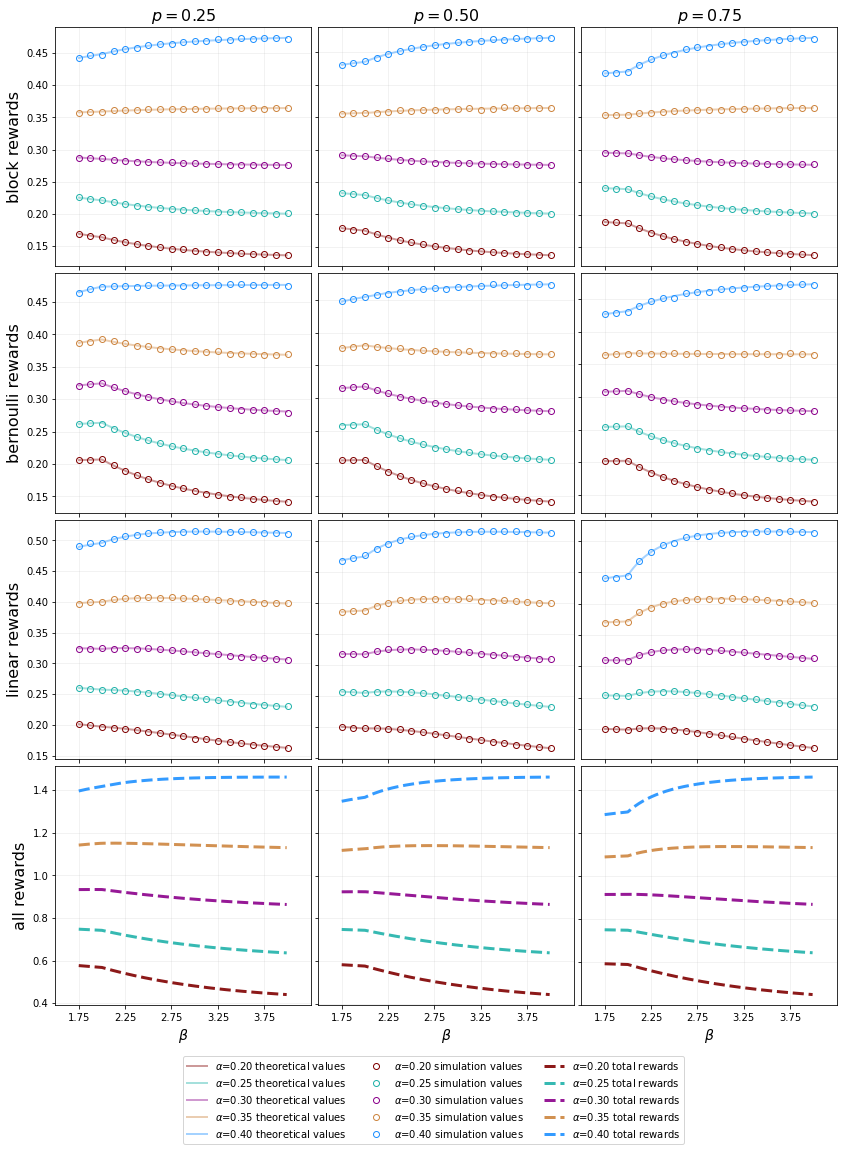

In [44]:
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(14,18))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[0,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_fixed[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theoretical values'.format(a_))
    ax = axarr[1,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_bern[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
    ax = axarr[2,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_lin[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))

for i in range(3):
    ax = axarr[0,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_fixed[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} simulation values'.format(a_))
    ax = axarr[1,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_bern[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
    ax = axarr[2,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_lin[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))

for i in range(3):
    ax = axarr[3,i]
    for j, a_ in enumerate(alphas):
        all_rews = theo_res_fixed[j,:,i] + theo_res_bern[j,:,i] + theo_res_lin[j,:,i]
        line, = ax.plot(betas, all_rews, linewidth=3, color=colors[j], alpha=0.9, linestyle='--',
                       label=r'$\alpha$={:0.2f} total rewards'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} total rewards'.format(a_))

        
for i, ax in enumerate(axarr.flatten()):
    ax.grid(alpha=0.2)
    ax.set_xlim(1.5, 4.25)
    ax.set_xticks(np.arange(1.75,4.01,0.5))
    

f.subplots_adjust(wspace=0.03, hspace=0.03)


for i, ax in enumerate(axarr[0]):
    ax.set_yticks(np.arange(0.15,0.451,0.05))
    ax.set_title(r'$p={:0.2f}$'.format(ps[i]), size=16)
    
for i, ax in enumerate(axarr[1]):
    ax.set_yticks(np.arange(0.15,0.451,0.05))

for i, ax in enumerate(axarr[3]):
    ax.set_xlabel(r'$\beta$', size=14)
    
for i in range(4):
    axarr[i,1].set_yticklabels([])
    axarr[i,2].set_yticklabels([])
#     axarr[i,1].set_xticklabels([])
#     axarr[i,2].set_xticklabels([])

axarr[0,0].set_ylabel(r'block rewards', size=16)
axarr[1,0].set_ylabel(r'bernoulli rewards', size=16)
axarr[2,0].set_ylabel(r'linear rewards', size=16)
axarr[3,0].set_ylabel(r'all rewards', size=16)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.09), ncol=3)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# optimal betas with both types of rewards

In [243]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1.})

In [246]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [274]:
def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

In [292]:
alphas = np.arange(0.01, 0.5, 0.01)
betas  = np.arange(1.01, 8.1, 0.01)
p_     = float(1e-16)
gammas = [0., 0.25, 0.5]

opt_beta_linear = []
opt_beta_total  = []
for g_ in gammas:
    temp1, temp2 = [], []
    for a_ in tqdm(alphas):
        fulls = [LinAndBlockRewards(a_=a_, b_=b_, p_=p_, g_=g_, C_=1.) for b_ in betas]
        lins  = [LinRewards(a_=a_, b_=b_, p_=p_, g_=g_, C_=1.) for b_ in betas]
        temp1.append(betas[np.argmax(fulls)])
        temp2.append(betas[np.argmax(lins)])
    opt_beta_total.append(temp1)
    opt_beta_linear.append(temp2)
opt_beta_total  = np.array(opt_beta_total)
opt_beta_linear = np.array(opt_beta_linear)
opt_beta_linear.shape, opt_beta_total.shape

100%|██████████| 49/49 [00:16<00:00,  2.96it/s]


((3, 49), (3, 49))

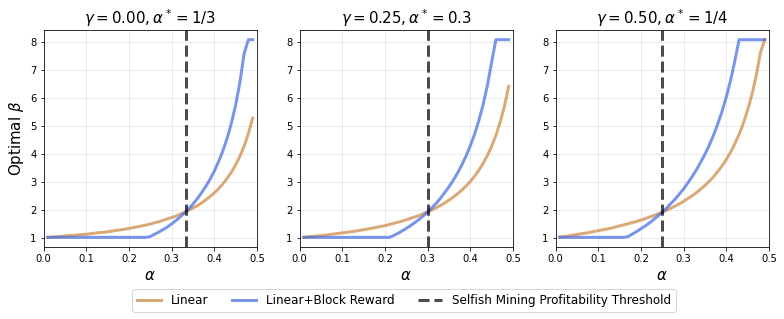

In [300]:
f, axarr = plt.subplots(ncols=3, figsize=(13,4))
for i in range(3):
    axarr[i].plot(alphas, opt_beta_linear[i], label=r'Linear', color='peru', 
                  linestyle='-', linewidth=3, alpha=0.7) 
    axarr[i].plot(alphas, opt_beta_total[i], label=r'Linear+Block Reward', color='royalblue', 
                  linestyle='-', linewidth=3, alpha=0.7)

for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$\alpha$', size=15)
    ax.set_xlim(0,0.5)
    
axarr[0].set_ylabel(r'Optimal $\beta$', size=15)
axarr[0].set_title(r'$\gamma=0.00, \alpha^*=1/3$', size=15)
axarr[1].set_title(r'$\gamma=0.25, \alpha^*=0.3$', size=15)
axarr[2].set_title(r'$\gamma=0.50, \alpha^*=1/4$', size=15)

axarr[0].axvline(1/3, color='k', linewidth=3, alpha=0.7, linestyle='--', label='Selfish Mining Profitability Threshold')
axarr[1].axvline(0.3, color='k', linewidth=3, alpha=0.7, linestyle='--')
axarr[2].axvline(1/4, color='k', linewidth=3, alpha=0.7, linestyle='--')


handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.51, -0.12), ncol=3, fontsize=12)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Threshold alphas

In [587]:
attack_full_lin

a**2*p_1*(3 - 2*a)/(1 - 2*a) + p_1*(2*a*(1 - a) + a) + p_1*(a*p*(-C - E + b + 1)*exp(C + E - b) + a*(1 - p)*(-C + b + 1)*exp(C - b) + a*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1)) + (1 - a)*(a + g*(1 - a))*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1)))/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [493]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1.})

In [494]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
honest_final_bern_lambda    = sp.lambdify((a, b, p, g, C), honest_final_bern)
attacker_final_bern_lambda  = sp.lambdify((a, b, p, g, C), attacker_final_bern)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [495]:
def BlockRewards(a_, b_, p_, g_, C_):
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return a_fixed/(a_fixed+h_fixed)

def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

def FullRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    a_bern  = attacker_final_bern_lambda(a_, b_, p_, g_, C_)
    h_bern  = honest_final_bern_lambda(a_, b_, p_, g_, C_)
    return (lin + a_fixed/(a_fixed+h_fixed) + a_bern/(a_bern+h_bern))/3

In [545]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.005)
betas = np.arange(1.01, 5.01, 0.05)
p_ = 0.5
C_ = 1.

In [422]:
FullRewards(a_, bestBeta, p_, g_, C_)

0.19648202274333584

In [546]:
b_res  = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [BlockRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            b_res.append(a_)
            break        
b_res = np.array(b_res)
b_res.shape

100%|██████████| 99/99 [01:31<00:00,  1.08it/s]


(99,)

In [547]:
l_res  = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [LinRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

100%|██████████| 99/99 [00:36<00:00,  2.73it/s]


(99,)

In [548]:
f_res = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [FullRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

100%|██████████| 99/99 [02:38<00:00,  1.60s/it]


(99,)

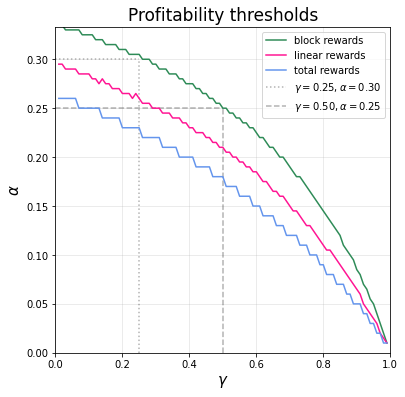

In [549]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# making it more efficient

In [699]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.0025)
betas = np.arange(1.01, 5.01, 0.01)

In [700]:
p_ = 0.5
C_ = 1.

In [701]:
p1_ev = p1_sym.evalf(subs={C:1., E:1., p:0.5})
p1_ev

a*(-1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.0*a - 2.71828182845905*a*exp(-b) + 0.5*Min(1.0, 7.38905609893065*exp(-b)) - 1.0 + 1.35914091422952*exp(-b))/(-1.5*a**2*Min(1.0, 7.38905609893065*exp(-b)) + 3.0*a**2 - 4.07742274268857*a**2*exp(-b) + 1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.71828182845905*a*exp(-b) - 1.0)

In [702]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})

In [703]:
br = sp.simplify(attacker_final_fixed/(attacker_final_fixed+honest_final_fixed))
br_lambda = sp.lambdify((a,b,g), br, 'numpy')
br_lambda = np.vectorize(br_lambda)
br_lambda

In [704]:
lin = sp.simplify(attack_final_lin)
lin_lambda = sp.lambdify((a,b,g), lin)
lin_lambda

<function _lambdifygenerated(a, b, g)>

In [705]:
bern = sp.simplify(attack_final_bern/(attack_final_bern+honest_final_bern))

In [713]:
full = (br + lin + bern)/3
full_lambda = sp.lambdify((a,b,g), full)

In [730]:
starting_alphas = np.linspace(0.25, 0.0, len(gammas))
starting_alphas = starting_alphas**(1/6)-0.57

In [709]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        br_lambda = np.vectorize(sp.lambdify((b), br.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = br_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

99it [02:03,  1.25s/it]


(99,)

In [710]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        lin_lambda = np.vectorize(sp.lambdify((b), lin.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = lin_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

99it [01:18,  1.26it/s]


(99,)

In [732]:
f_res = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        full_lambda_inner = np.vectorize(sp.lambdify((b), full.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = full_lambda_inner(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

99it [02:05,  1.27s/it]


(99,)

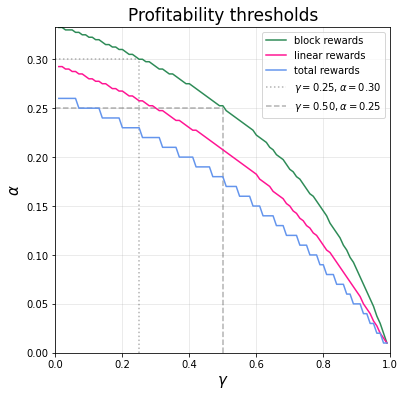

In [733]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas**(1/6)-0.57, label='total rewards', color='cornflowerblue')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

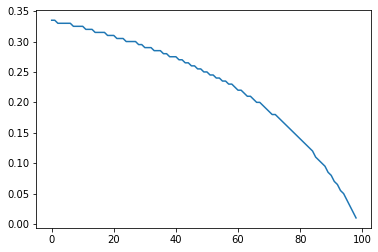

In [632]:
plt.plot(b_res)

# profit as function of alpha

In [412]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [413]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [414]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [415]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [416]:
# confirming the symbolic solver and my by hand solver have same values
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [417]:
# 3 cases for f0
f0i_fixed   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii_fixed  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [418]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)
f0_fixed

C*a*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(a*p*Min(1, exp(C + E - b)) + a*(1 - p)*exp(C - b))

In [419]:
attack_full_fixed  = p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a))
sp.simplify(attack_full_fixed)

C*p_1*(2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + p*Min(1, exp(C + E - b)) + (a - 1)*(a - g*(a - 1))*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (p - 1)*exp(C - b)))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [420]:
f0i_bern   = E * (a*p*sp.Min(1,sp.exp(-b+C+E)))
f0ii_bern  = a*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp(C + E - b)))*(a + g*(1 - a))

In [421]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [422]:
attack_full_bern  = p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a))
sp.simplify(attack_full_bern)

E*p*p_1*(2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(Min(1, exp(C + E - b)) - 1) + (a - 1)*(a - g*(a - 1))*(Min(1, exp(C + E - b)) - 1) + Min(1, exp(C + E - b))))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [423]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*(b-C+1)*sp.exp(-b+C)
f0ii_lin  = a* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C))) 
f0iii_lin = ((1-a)*(a+g*(1-a)))* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C)))
f0iii_lin

(1 - a)*(a + g*(1 - a))*(a*p*(-(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1))

In [424]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = a + 2*a*(1-a)

In [425]:
attack_full_lin = p0*f0_lin + p1*f1_lin + p1*a*a*(3-2*a)/(1-2*a)
sp.simplify(attack_full_lin)

p_1*(a**2*(2*a - 3)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(2*a - 3)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(p*((Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - 1) - (p - 1)*((-C + b + 1)*exp(C - b) - 1)) + p*(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) + (a - 1)*(a - g*(a - 1))*(p*((Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - 1) - (p - 1)*((-C + b + 1)*exp(C - b) - 1)) - (p - 1)*(-C + b + 1)*exp(C - b)))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [142]:
# params: a, b, g, p, C, E

In [426]:
full      = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym})
linAndFix = (attack_full_fixed + attack_full_lin).subs({p1:p1_sym})
full.subs({a:0.3, b:3.3, g:0.5, p:0.25, C:1., E:1.}),full.subs({a:0.3, b:1.01, g:0.5, p:0.25, C:1., E:1.})

(0.670148302278976, 0.675420045583400)

In [427]:
attack_full_bern.subs({p1:p1_sym}).subs({a:0.3, b:1.01, p:0.25, C:1., E:4.})

0.299999999999998

In [428]:
attack_full_bern.subs({a:0.3, b:3.01, p:0.25, C:1., E:4.})

2.3646257466072*p_1

In [429]:
alphas = np.arange(0.01, 0.50, 0.01)
betas  = np.arange(1.001, 10, 0.01)
gammas = [0.0, 0.5, 1.0]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.33

In [430]:
selfish_rews = []
total_rews   = []
lin_fix_rews = []
for i, a_ in tqdm(enumerate(alphas)):
    selfish = full.subs({a:a_, b:100., g:g_, p:p_, C:C_, E:E_})
    selfish_rews.append(selfish)
    
    opt_over = np.vectorize(sp.lambdify(b, full.subs({a:a_, g:g_, p:p_, C:C_, E:E_})))
    totals   = opt_over(betas)
    opt_beta = betas[np.argmax(totals)]
    total    = full.subs({a:a_, b:opt_beta, g:g_, p:p_, C:C_, E:E_})
    total_rews.append(total)
    
    opt_over   = np.vectorize(sp.lambdify(b, linAndFix.subs({a:a_, g:g_, p:p_, C:C_, E:E_})))
    linAndFixs = opt_over(betas)
    opt_beta   = betas[np.argmax(linAndFixs)]
    linfix     = full.subs({a:a_, b:opt_beta, g:g_, p:p_, C:C_, E:E_})
    lin_fix_rews.append(linfix)
    

selfish_rews = np.array(selfish_rews)
total_rews = np.array(total_rews)
lin_fix_rews = np.array(lin_fix_rews)
selfish_rews.shape, total_rews.shape, lin_fix_rews.shape

49it [00:11,  4.40it/s]


((49,), (49,), (49,))

In [431]:
total_rews.shape

(49,)

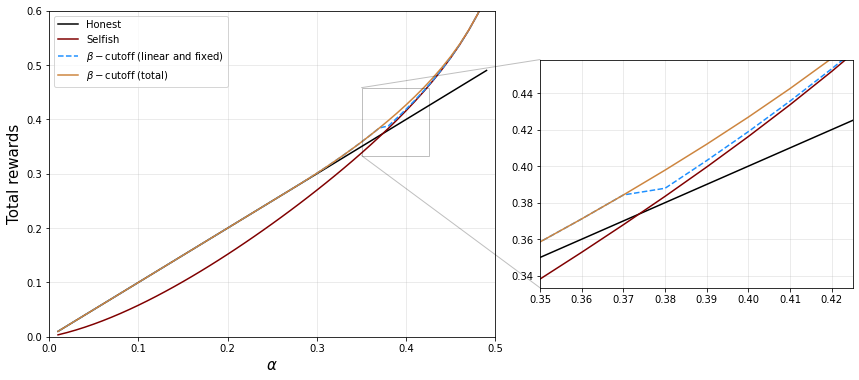

In [439]:
f, ax = plt.subplots(figsize=(8,6))

axins = ax.inset_axes(
    [1.1, 0.15, 0.7, 0.7],
    xlim=(.35, .425), ylim=(1/3, 1.375/3))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)


for ax_ in [ax, axins]:
    ax_.plot(alphas, alphas, label='Honest', color='black')
    ax_.plot(alphas, selfish_rews/3, label='Selfish', color='maroon')
    ax_.plot(alphas, lin_fix_rews/3, label=r'$\beta-$cutoff (linear and fixed)', color='dodgerblue',
         linestyle='--')
    ax_.plot(alphas, total_rews/3, label=r'$\beta-$cutoff (total)', color='peru')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Total rewards', size=15)
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.6)
ax.legend()

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# total as a function of gamma w/ sims

In [399]:
alphas = np.arange(0.01, 0.50, 0.01)
betas  = np.arange(1.001, 10, 0.01)
gammas = [0.0, 1/3, 2/3, 1]
p_     = 0.25
E_     = 4.
C_     = 1.

In [400]:
total_rews   = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        opt_over = np.vectorize(sp.lambdify(b, full.subs({a:a_, g:g_, p:p_, C:C_, E:E_})))
        totals   = opt_over(betas)
        opt_beta = betas[np.argmax(totals)]
        total    = full.subs({a:a_, b:opt_beta, g:g_, p:p_, C:C_, E:E_})
        temp.append(total)
    total_rews.append(temp)
total_rews = np.array(total_rews)
total_rews.shape

49it [00:07,  6.79it/s]
49it [00:07,  6.83it/s]
49it [00:07,  6.86it/s]
49it [00:04, 10.77it/s]


(4, 49)

In [393]:
simAlphas = np.arange(0.32, 0.481, 0.02)
simAlphas

array([0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48])

In [394]:
sim_res = []
n = int(4e4)
for g_ in gammas:
    temp = []
    for a_ in tqdm(simAlphas):
        opt_over = np.vectorize(sp.lambdify(b, full.subs({a:a_, g:g_, p:p_, C:C_, E:E_})))
        totals   = opt_over(betas)
        opt_beta = betas[np.argmax(totals)]
        honestBlc, attackBlc, honestBer, attackBer, honestLin, attackLin, time = simAllRews(
            a=a_, b=opt_beta, g=g_, p=p_, C=C_, E=E_, n=n)
#         temp.append(attackBlc/time + attackLin/time + attackBer*E/(time*p_*E_))
        temp.append((attackBlc + attackBer + attackLin)/time)
            
    sim_res.append(temp)
sim_res = np.array(sim_res)
sim_res.shape

100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


(4, 9)

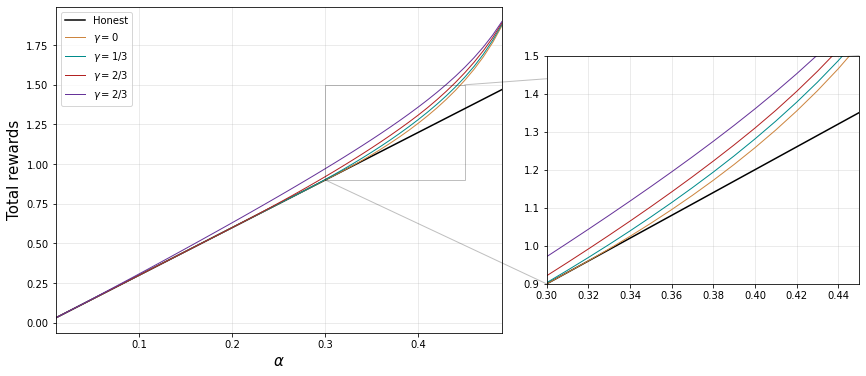

In [410]:
f, ax = plt.subplots(figsize=(8,6))

axins = ax.inset_axes(
    [1.1, 0.15, 0.7, 0.7],
    xlim=(.3, .45), ylim=(0.9, 1.5))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)



for ax_ in [ax, axins]:
    ax_.plot(alphas, 3*alphas, label='Honest', color='black')
    ax_.plot(alphas, total_rews[0,:], label=r'$\gamma=0$', color='peru', linewidth=1)
    ax_.plot(alphas, total_rews[1,:], label=r'$\gamma=1/3$', color='darkcyan', linewidth=1)
    ax_.plot(alphas, total_rews[2,:], label=r'$\gamma=2/3$', color='firebrick', linewidth=1)
    ax_.plot(alphas, total_rews[3,:], label=r'$\gamma=2/3$', color='rebeccapurple', linewidth=1)
    ax_.grid(alpha=0.3)


ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Total rewards', size=15)
ax.set_xlim(0.01,0.49)
ax.legend()

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# simplifications 

In [45]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [46]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [47]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [48]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [49]:
# confirming the symbolic solver and my by hand solver have same values
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [55]:
# 3 cases for f0
f0i_fixed   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii_fixed  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [56]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)
f0_fixed

C*a*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(a*p*Min(1, exp(C + E - b)) + a*(1 - p)*exp(C - b))

In [57]:
attack_full_fixed  = p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a))
sp.simplify(attack_full_fixed)

C*p_1*(2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + p*Min(1, exp(C + E - b)) + (a - 1)*(a - g*(a - 1))*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (p - 1)*exp(C - b)))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [58]:
f0i_bern   = E * (a*p*sp.Min(1,sp.exp(-b+C+E)))
f0ii_bern  = a*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp(C + E - b)))*(a + g*(1 - a))

In [59]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [60]:
attack_full_bern  = p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a))
sp.simplify(attack_full_bern)

E*p*p_1*(2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(Min(1, exp(C + E - b)) - 1) + (a - 1)*(a - g*(a - 1))*(Min(1, exp(C + E - b)) - 1) + Min(1, exp(C + E - b))))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [61]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*(b-C+1)*sp.exp(-b+C)
f0ii_lin  = a* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C))) 
f0iii_lin = ((1-a)*(a+g*(1-a)))* (a*p*(1-(sp.Max(0,b-C-E)+1)*sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C)))
f0iii_lin

(1 - a)*(a + g*(1 - a))*(a*p*(-(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1))

In [62]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = a + 2*a*(1-a)

In [63]:
attack_full_lin = p0*f0_lin + p1*f1_lin + p1*a*a*(3-2*a)/(1-2*a)
sp.simplify(attack_full_lin)

p_1*(a**2*(2*a - 3)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(2*a - 3)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - (2*a - 1)*(-a*(p*((Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - 1) - (p - 1)*((-C + b + 1)*exp(C - b) - 1)) + p*(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) + (a - 1)*(a - g*(a - 1))*(p*((Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - 1) - (p - 1)*((-C + b + 1)*exp(C - b) - 1)) - (p - 1)*(-C + b + 1)*exp(C - b)))/((2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)))

In [67]:
sp.simplify(sp.simplify(attack_full_lin) + sp.simplify(attack_full_bern) + sp.simplify(attack_full_fixed))

p_1*(C*(2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + (2*a - 1)*(a*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - p*Min(1, exp(C + E - b)) - (a - 1)*(a - g*(a - 1))*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + (p - 1)*exp(C - b))) - E*p*(-2*a**2*(a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + a*(a - 2)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + (2*a - 1)*(-a*(Min(1, exp(C + E - b)) - 1) + (a - 1)*(a - g*(a - 1))*(Min(1, exp(C + E - b)) - 1) + Min(1, exp(C + E - b)))) + a**2*(2*a - 3)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) - a*(2*a - 3)*(2*a - 1)*(p*(Min(1, exp(C + E - b)) - 1) + (1 - exp(C - b))*(p - 1)) + (2*a - 1)*(a*(p*((Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - 1) - (p - 1)*((-C + b + 1)*exp(C - b) - 1)) - p*(Max(0, -C - E + b) + 1)*Min(1, exp(C + E - b)) - (a -

In [494]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
honest_final_bern_lambda    = sp.lambdify((a, b, p, g, C), honest_final_bern)
attacker_final_bern_lambda  = sp.lambdify((a, b, p, g, C), attacker_final_bern)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [495]:
def BlockRewards(a_, b_, p_, g_, C_):
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return a_fixed/(a_fixed+h_fixed)

def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

def FullRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    a_bern  = attacker_final_bern_lambda(a_, b_, p_, g_, C_)
    h_bern  = honest_final_bern_lambda(a_, b_, p_, g_, C_)
    return (lin + a_fixed/(a_fixed+h_fixed) + a_bern/(a_bern+h_bern))/3

In [545]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.005)
betas = np.arange(1.01, 5.01, 0.05)
p_ = 0.5
C_ = 1.

In [ ]:
p_ = 0.5
g_ = 0.1

In [508]:
a_ = 0.26

In [509]:
bs = [LinRewards(a_, b_, p_, g_, C_) for b_ in betas]
bestBeta = betas[np.argmax(bs)]
bestBeta, FullRewards(a_, bestBeta, p_, g_, C_)

(2.360000000000001, 0.2551061712501037)

In [510]:
bs = [FullRewards(a_, b_, p_, g_, C_) for b_ in betas]
bestBeta = betas[np.argmax(bs)]
bestBeta, FullRewards(a_, bestBeta, p_, g_, C_)

(1.8600000000000008, 0.26223290139728433)

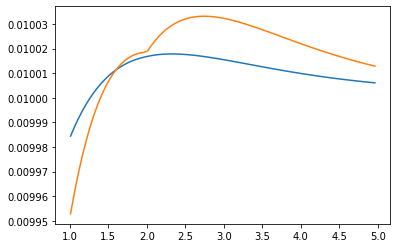

In [519]:
plt.plot(betas,[FullRewards(a_, b_, p_, g_, C_)for b_ in betas])
plt.plot(betas, [LinRewards(a_, b_, p_, g_, C_)for b_ in betas])

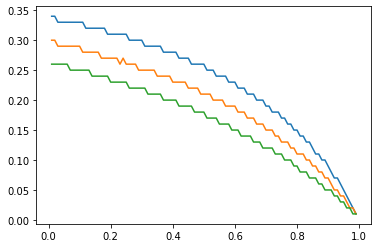

In [517]:
plt.plot(gammas, b_res)
plt.plot(gammas, l_res)
# plt.plot(gammas, bl_res)
plt.plot(gammas, f_res)